<a href="https://colab.research.google.com/github/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/thinking_blackbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install category_encoders

In [0]:
import category_encoders as ce
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Load data from https://www.kaggle.com/c/ds1-tree-ensembles/data
train_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/train_features.csv"
label_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/train_labels.csv"
test_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/test_features.csv"
submission_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/sample_submission.csv"
LCDataDictionary_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/LCDataDictionary.xlsx"

X_train = pd.read_csv(train_url)
y_train = pd.read_csv(label_url)['charged_off']
X_test = pd.read_csv(test_url)
df_submission = pd.read_csv(submission_url)
X_Dict = pd.read_excel(LCDataDictionary_url)

def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# Wrangle train and test in the same way
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [0]:
X = X_train
y = y_train

In [46]:
#How do Linear or Regression model think
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_val)

rf = RandomForestClassifier(n_estimators=100, 
        class_weight='balanced', 
        min_samples_leaf=0.005, )
rf.fit(X_train, y_train)
rf_pred_proba = rf.predict_proba(X_val)[:,1]

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred_proba = gb.predict_proba(X_val)[:,1]

print('LogisticRegression Accuracy:', accuracy_score(y_val, lr_pred))
print('RandomForest ROC AUC:', roc_auc_score(y_val, rf_pred_proba))
print('GradientBoosting ROC AUC:', roc_auc_score(y_val, gb_pred_proba))



LogisticRegression Accuracy: 0.8532255927937475
RandomForest ROC AUC: 0.7273794015002618
GradientBoosting ROC AUC: 0.7445684922639515


Both RandomForest and GradientBoosting are from the ensemble data model family. They both behave similarly and see the world as multiple factors causing a root cause. Logistic regression belongs to the Linear data model which sees the world with simplistic one-to-one straight line cause-effect relationship.

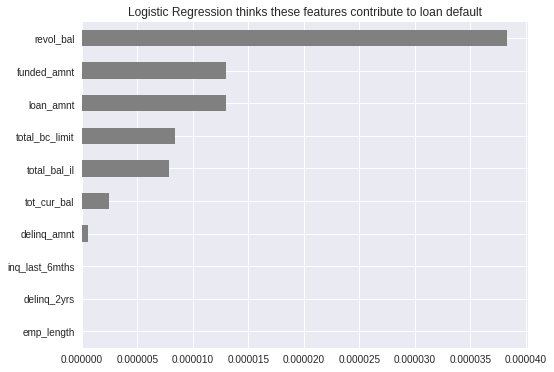

In [47]:
#Logistic regression thinks revolving balances has most impact on model predictions on positive loan defaults.
feature_importances = pd.Series(lr.coef_[0], X.columns)
top_10 = feature_importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(8, 6))
plt.title('Logistic Regression thinks these features contribute to loan default')
top_10.sort_values().plot.barh(color='grey')

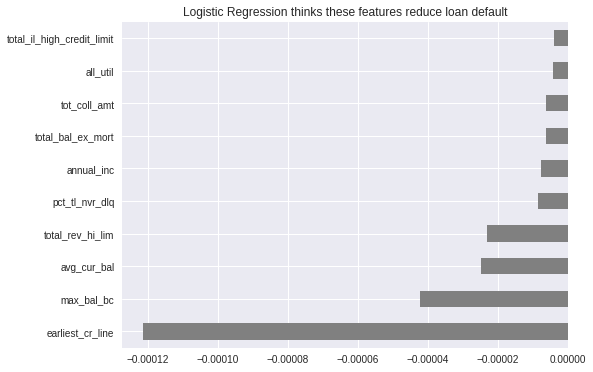

In [48]:
# Conversely Logistic Regression thinks earliest credit line affects the most on negative loan default or no loan default.
feature_importances = pd.Series(lr.coef_[0], X.columns)
lower_10 = feature_importances.sort_values()[:10]
plt.figure(figsize=(8, 6))
plt.title('Logistic Regression thinks these features reduce loan default')
lower_10.sort_values().plot.barh(color='grey')


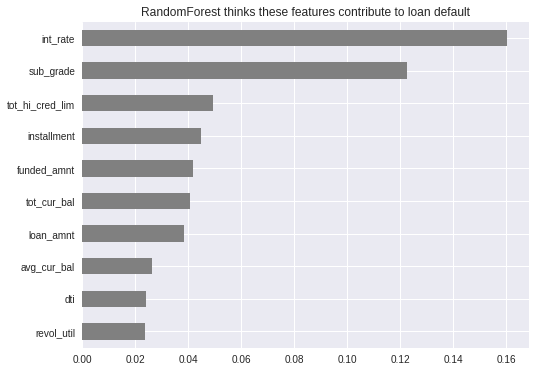

In [21]:
# RandomForest thinks interest rate follows by sub grade loan, has most influence on model predicion of positive loans default.
importances = pd.Series(rf.feature_importances_, X.columns)
top_n = importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(8, 6))
plt.title('RandomForest thinks these features contribute to loan default')
top_n.sort_values().plot.barh(color='grey')

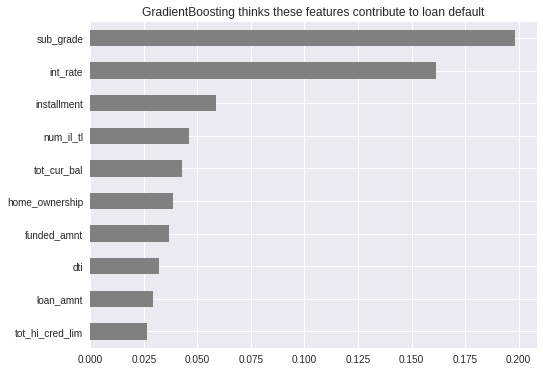

In [49]:
#GradientBoosting also thinks interest rate and sub grade loans have most influence on load default outcome.

importances = pd.Series(gb.feature_importances_, X.columns)
top_n = importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(8, 6))
plt.title('GradientBoosting thinks these features contribute to loan default')
top_n.sort_values().plot.barh(color='grey')

In [50]:
!pip install pdpbox

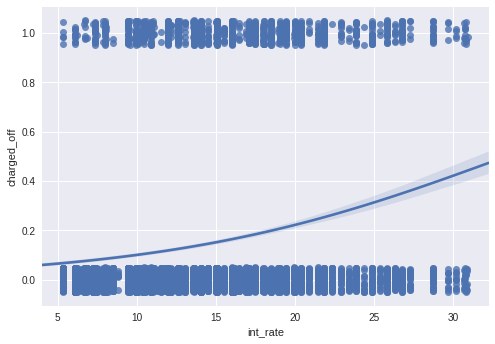

In [51]:
import seaborn as sns

sns.regplot(x=X_val['int_rate'], y=y_val, logistic=True, y_jitter=.05);

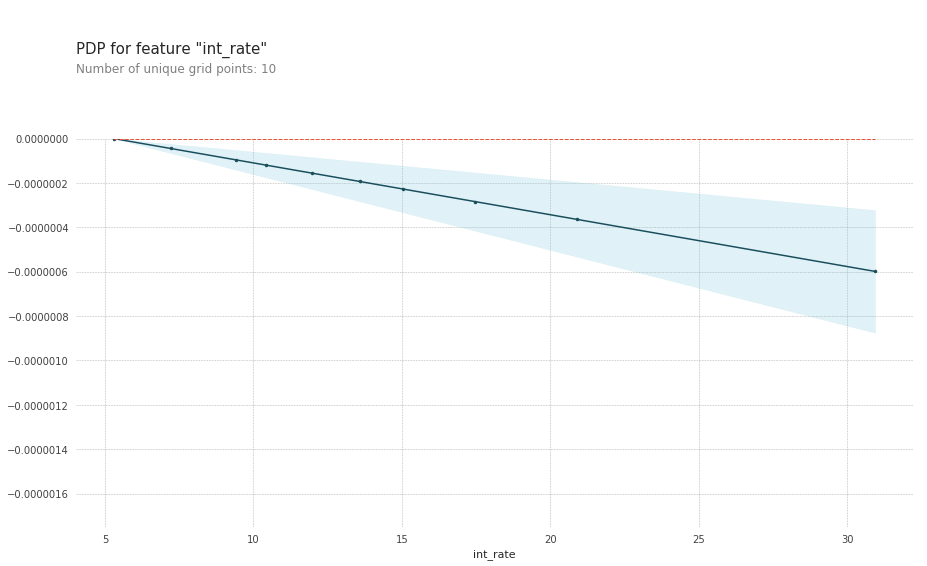

In [52]:
# Simplistic straight line views from Logistic Regression, projecting higher loan interest rate has lower loan default probability.
feature='int_rate'
pdp_isolated = pdp_isolate(model=lr, dataset=X_val, model_features=X_val.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

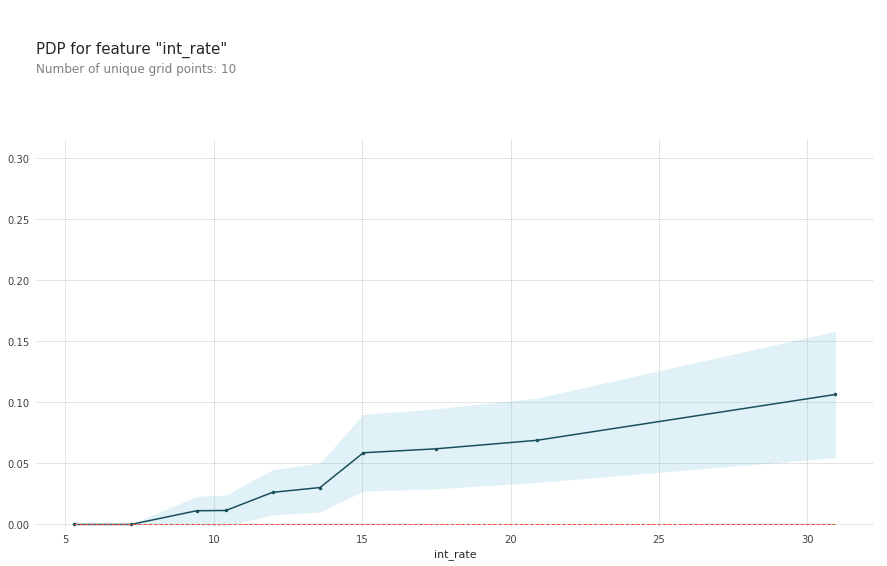

In [53]:
# How RandomForest and GradientBoosting model see lower interest rate lower loan default. 
# A rise of interest rate to 15 and beyond 20, raises the odd of loan default.
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='int_rate'
pdp_isolated = pdp_isolate(model=gb, dataset=X_val, model_features=X_val.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

Since the predictions of data models range from 70-80% accuracy, this means 20-30% predictions made, are wrong during the training and validation phase of data model buildings.



In [0]:
# Examine data model cases of wrong prediction.
import numpy as np
rf_pred = (rf_pred_proba >= 0.5).astype(int)
confidence = np.abs(rf_pred_proba - 0.5)
preds = pd.DataFrame({'y_val': y_val, 'rf_pred': rf_pred, 'rf_pred_proba': rf_pred_proba, 'confidence': confidence})

In [56]:
# True positives, with high confidence
preds[(y_val==1) & (rf_pred==1)].sort_values(by='confidence', ascending=False).head(3)

,confidence,rf_pred,rf_pred_proba,y_val
19833,0.283510,1,0.783510,1
24827,0.281938,1,0.781938,1
24239,0.280980,1,0.780980,1


In [57]:
# For case 19833, RandomForest correctly predicted loan default and these were the dimensional features that RandomForest used to make the prediction.
import shap

data_for_prediction = X_val.loc[19833]
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [40]:
# False positives, with high (mistaken) confidence
preds[(y_val==0) & (rf_pred==1)].sort_values(by='confidence', ascending=False).head(3)

,confidence,rf_pred,rf_pred_proba,y_val
31995,0.267696,1,0.767696,0
29415,0.255534,1,0.755534,0
17141,0.253162,1,0.753162,0


In [39]:
# False positive by RandomForest for cases 31995
import shap

data_for_prediction = X_val.loc[31995]
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [37]:
!pip install shap

    100% |████████████████████████████████| 225kB 11.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap
